In [1]:
import os
import numpy as np
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Conv2D, MaxPooling2D, Dropout,
                                     Flatten, Dense, BatchNormalization)
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [2]:
data_path = r"C:\Users\Asus\OneDrive\Documents\Kuliah\Sem 4\Research Methodology\RM MODEL\ChoralSingingDataset"
SAMPLE_RATE = 22050
SEGMENT_DURATION = 2  # durasi per segmen (detik)
N_MFCC = 13


In [3]:
def extract_features(y, sr):
    if len(y) < sr * SEGMENT_DURATION:
        y = np.pad(y, (0, sr * SEGMENT_DURATION - len(y)))

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
    pitch = librosa.yin(y, fmin=50, fmax=300)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)

    features = np.concatenate([
        np.mean(mfcc, axis=1),
        [np.mean(pitch)],
        np.mean(chroma, axis=1),
        np.mean(contrast, axis=1),
        np.mean(zcr, axis=1)
    ])
    return features

In [4]:
def load_segmented_features(data_path):
    X, y = [], []
    for file in os.listdir(data_path):
        if not file.endswith('.wav') or 'midi' in file or 'notes' in file:
            continue

        label = next((part.capitalize() for part in ['soprano', 'alto', 'tenor', 'bass'] if part in file.lower()), None)
        if not label:
            continue

        y_raw, sr = librosa.load(os.path.join(data_path, file), sr=SAMPLE_RATE)
        segment_len = sr * SEGMENT_DURATION

        for start in range(0, len(y_raw) - segment_len + 1, segment_len):
            y_seg = y_raw[start:start + segment_len]
            feat = extract_features(y_seg, sr)
            X.append(feat)
            y.append(label)

    return np.array(X), np.array(y)

In [5]:
print("Loading and extracting features...")
X, y = load_segmented_features(data_path)

print("Encoding labels...")
le = LabelEncoder()
y_enc = le.fit_transform(y)
y_cat = to_categorical(y_enc)

print("Splitting data...")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)
X_train_cat, X_test_cat = train_test_split(y_cat, test_size=0.2, random_state=42, stratify=y_enc)

Loading and extracting features...


c:\Users\Asus\anaconda3\Lib\site-packages\paramiko\pkey.py:82: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "cipher": algorithms.TripleDES,
c:\Users\Asus\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.Blowfish and will be removed from this module in 45.0.0.
  "class": algorithms.Blowfish,
c:\Users\Asus\anaconda3\Lib\site-packages\paramiko\transport.py:243: CryptographyDeprecationWarning: TripleDES has been moved to cryptography.hazmat.decrepit.ciphers.algorithms.TripleDES and will be removed from this module in 48.0.0.
  "class": algorithms.TripleDES,
c:\Users\Asus\anaconda3\Lib\site-packages\librosa\core\pitch.py:103: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


Encoding labels...
Splitting data...


In [6]:
X_train_cnn = X_train.reshape(-1, X_train.shape[1], 1, 1)
X_test_cnn = X_test.reshape(-1, X_test.shape[1], 1, 1)

cnn_model = Sequential([
    Conv2D(64, (3, 1), activation='relu', input_shape=X_train_cnn.shape[1:]),
    BatchNormalization(),
    MaxPooling2D((2, 1)),
    Dropout(0.3),

    Conv2D(128, (3, 1), activation='relu'),
    BatchNormalization(),
    MaxPooling2D((2, 1)),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(4, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

print("Training CNN model...")
history_cnn = cnn_model.fit(
    X_train_cnn, y_train, epochs=100, batch_size=32,
    validation_split=0.2, callbacks=[early_stop], verbose=0
)

cnn_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)
print("\n=== CNN Classification Report ===")
print(classification_report(y_test, cnn_pred, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, cnn_pred))

c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Training CNN model...
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

=== CNN Classification Report ===
              precision    recall  f1-score   support

        Alto       0.95      0.92      0.94       173
        Bass       0.95      0.86      0.90       172
     Soprano       0.96      0.94      0.95       171
       Tenor       0.81      0.92      0.86       172

    accuracy                           0.91       688
   macro avg       0.92      0.91      0.91       688
weighted avg       0.92      0.91      0.91       688

Confusion Matrix:
[[160   3   1   9]
 [  2 148   0  22]
 [  2   2 160   7]
 [  5   3   5 159]]


In [7]:
bpnn_model = Sequential([
    Dense(256, input_shape=(X.shape[1],), activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(4, activation='softmax')
])

bpnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("Training BPNN model...")
history_bpnn = bpnn_model.fit(
    X_train, y_train, epochs=100, batch_size=32,
    validation_split=0.2, callbacks=[early_stop], verbose=0
)

bpnn_pred = np.argmax(bpnn_model.predict(X_test), axis=1)
print("\n=== BPNN Classification Report ===")
print(classification_report(y_test, bpnn_pred, target_names=le.classes_))
print("Confusion Matrix:")
print(confusion_matrix(y_test, bpnn_pred))

Training BPNN model...


c:\Users\Asus\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 

=== BPNN Classification Report ===
              precision    recall  f1-score   support

        Alto       0.97      0.91      0.94       173
        Bass       0.91      0.91      0.91       172
     Soprano       0.95      0.94      0.94       171
       Tenor       0.83      0.89      0.86       172

    accuracy                           0.91       688
   macro avg       0.91      0.91      0.91       688
weighted avg       0.91      0.91      0.91       688

Confusion Matrix:
[[158   7   2   6]
 [  0 156   0  16]
 [  1   1 160   9]
 [  4   8   7 153]]


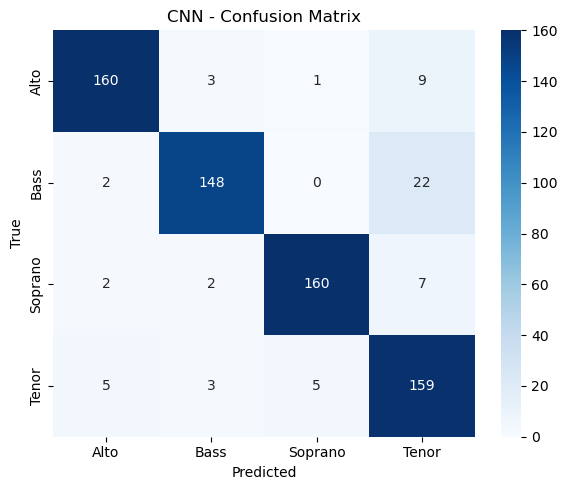

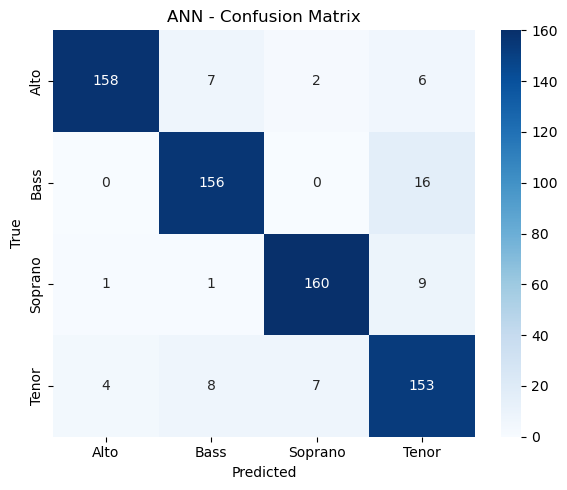

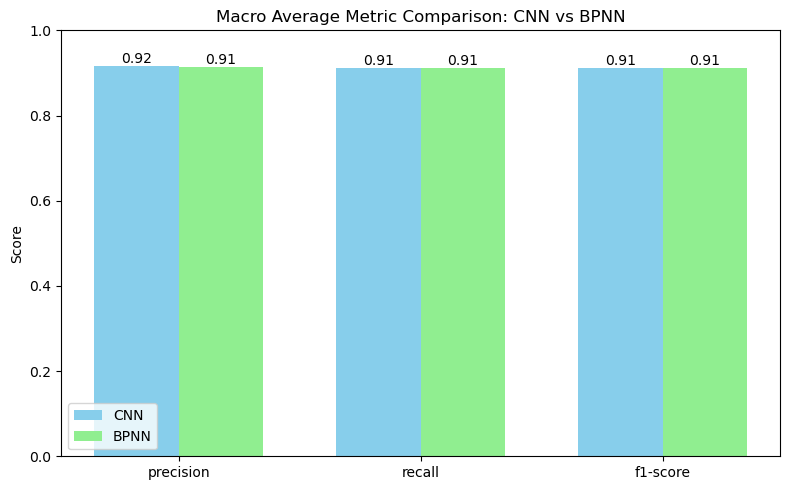

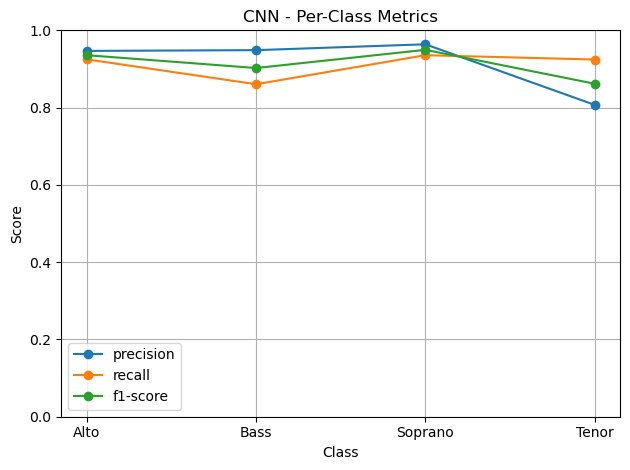

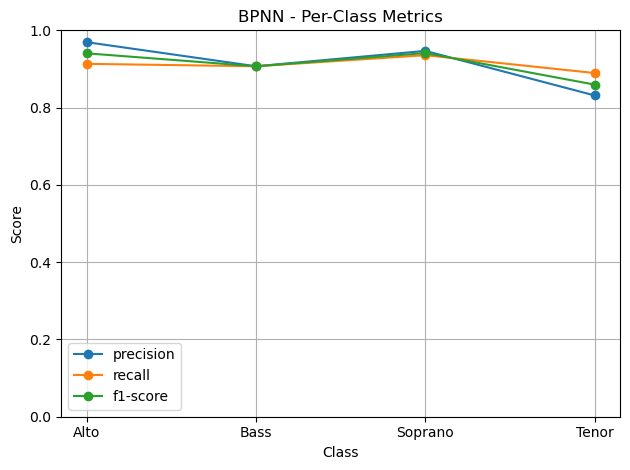

In [9]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Simpan hasil evaluasi
labels = le.classes_
cm_cnn = confusion_matrix(y_test, cnn_pred)
report_cnn = classification_report(y_test, cnn_pred, target_names=labels, output_dict=True)

cm_bpnn = confusion_matrix(y_test, bpnn_pred)
report_bpnn = classification_report(y_test, bpnn_pred, target_names=labels, output_dict=True)

# Plot Confusion Matrix
def plot_conf_matrix(cm, model_name):
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(f'{model_name} - Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

plot_conf_matrix(cm_cnn, "CNN")
plot_conf_matrix(cm_bpnn, "ANN")

# Plot Macro Metrics Comparison
metrics = ['precision', 'recall', 'f1-score']
cnn_scores = [report_cnn['macro avg'][m] for m in metrics]
bpnn_scores = [report_bpnn['macro avg'][m] for m in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, cnn_scores, width, label='CNN', color='skyblue')
bars2 = ax.bar(x + width/2, bpnn_scores, width, label='BPNN', color='lightgreen')

ax.set_ylabel('Score')
ax.set_title('Macro Average Metric Comparison: CNN vs BPNN')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_ylim(0, 1.0)
ax.legend()
ax.bar_label(bars1, fmt='%.2f')
ax.bar_label(bars2, fmt='%.2f')
plt.tight_layout()
plt.show()

# Plot per-class metric comparison
def plot_metric_per_class(report_dict, model_name):
    metrics = ['precision', 'recall', 'f1-score']
    for metric in metrics:
        values = [report_dict[label][metric] for label in labels]
        plt.plot(labels, values, marker='o', label=metric)

    plt.ylim(0, 1.0)
    plt.title(f'{model_name} - Per-Class Metrics')
    plt.xlabel('Class')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

plot_metric_per_class(report_cnn, "CNN")
plot_metric_per_class(report_bpnn, "BPNN")


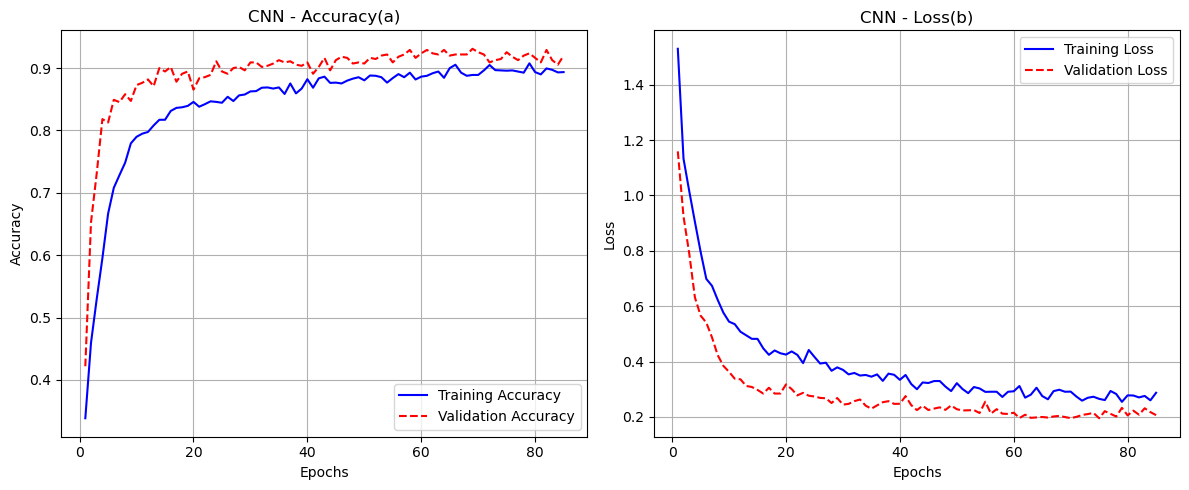

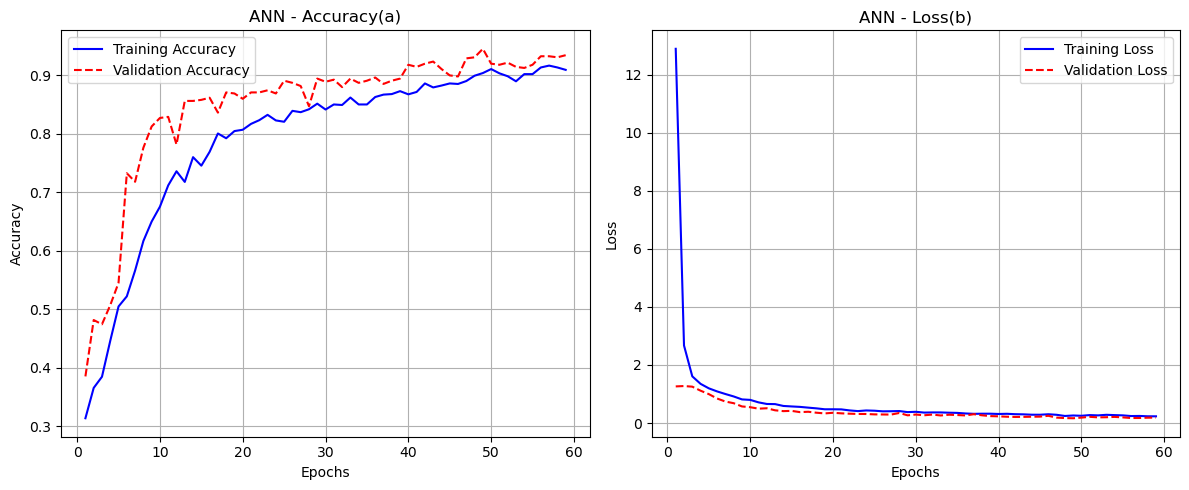

In [10]:
def plot_training_history(history, model_name):
    acc = history.history.get('accuracy')
    val_acc = history.history.get('val_accuracy')
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b-', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'r--', label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy(a)')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b-', label='Training Loss')
    plt.plot(epochs, val_loss, 'r--', label='Validation Loss')
    plt.title(f'{model_name} - Loss(b)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history_cnn, "CNN")
plot_training_history(history_bpnn, "ANN")


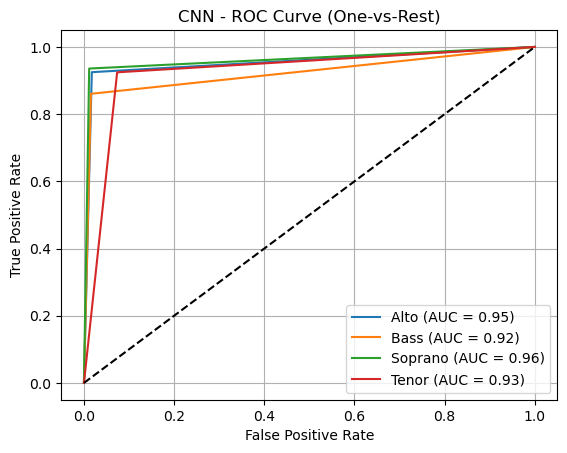

In [11]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier

# Hanya bisa jika y_test dalam bentuk binari
y_test_bin = label_binarize(y_test, classes=range(len(labels)))
cnn_pred_bin = label_binarize(cnn_pred, classes=range(len(labels)))

for i in range(len(labels)):
    fpr, tpr, _ = roc_curve(y_test_bin[:, i], cnn_pred_bin[:, i])
    plt.plot(fpr, tpr, label=f'{labels[i]} (AUC = {auc(fpr, tpr):.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN - ROC Curve (One-vs-Rest)')
plt.legend()
plt.grid()
plt.show()


22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


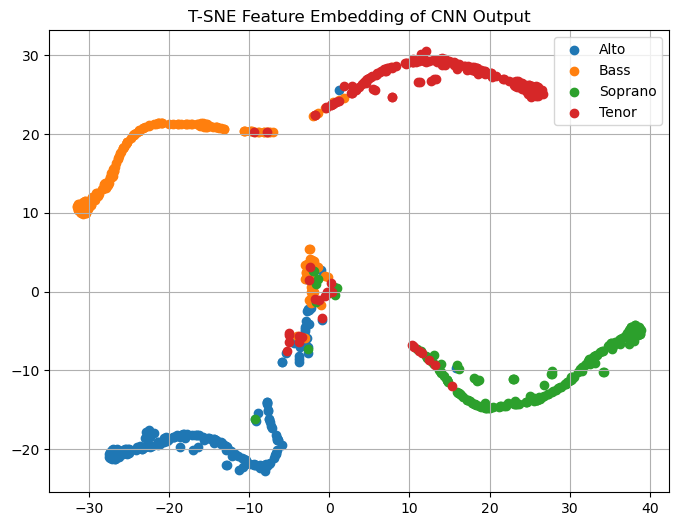

In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Ambil output dari layer CNN terakhir sebelum prediksi
features = cnn_model.predict(X_test_cnn)
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
for label in np.unique(y_test):
    idx = np.where(y_test == label)
    plt.scatter(tsne_result[idx, 0], tsne_result[idx, 1], label=labels[label])
plt.title("T-SNE Feature Embedding of CNN Output")
plt.legend()
plt.grid(True)
plt.show()


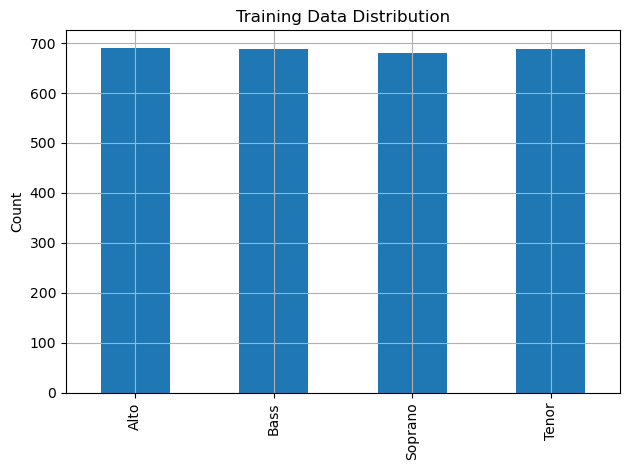

In [13]:
import pandas as pd

unique, counts = np.unique(y_train, return_counts=True)
train_dist = pd.Series(counts, index=[labels[u] for u in unique])
train_dist.plot(kind='bar', title='Training Data Distribution')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


In [14]:
from sklearn.model_selection import learning_curve
from math import pi

# Plot 4: Learning Curve
def plot_learning_curve(model, X, y, title="Learning Curve", scoring='accuracy'):
    from sklearn.model_selection import StratifiedKFold
    from scikeras.wrappers import KerasClassifier

    model_wrapper = KerasClassifier(model=model, epochs=50, batch_size=32, verbose=0)
    train_sizes, train_scores, test_scores = learning_curve(
        estimator=model_wrapper,
        X=X, y=y,
        train_sizes=np.linspace(0.1, 1.0, 5),
        cv=StratifiedKFold(n_splits=3),
        scoring=scoring,
        shuffle=True,
        random_state=42
    )
    
    train_mean = np.mean(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)

    plt.figure(figsize=(8, 5))
    plt.plot(train_sizes, train_mean, 'o-', label='Training Score')
    plt.plot(train_sizes, test_mean, 's--', label='Validation Score')
    plt.title(title)
    plt.xlabel("Training Set Size")
    plt.ylabel(scoring.capitalize())
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plot_learning_curve(model=build_cnn_model, X=X_train, y=y_train, title="Learning Curve - CNN")

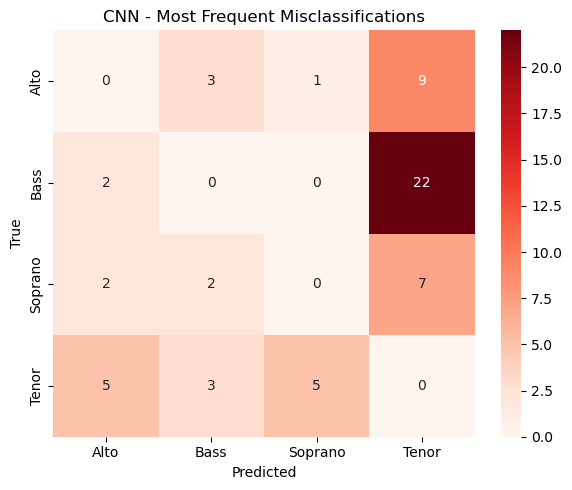

In [15]:
import seaborn as sns
import pandas as pd

# Hitung jenis kesalahan
df_misclassified = pd.DataFrame({'True': y_test, 'Predicted': cnn_pred})
conf_err = df_misclassified[df_misclassified['True'] != df_misclassified['Predicted']]
err_counts = conf_err.groupby(['True', 'Predicted']).size().unstack().fillna(0)

plt.figure(figsize=(6, 5))
sns.heatmap(err_counts, annot=True, cmap='Reds', fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.title('CNN - Most Frequent Misclassifications')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()


In [16]:
def plot_radar(report_dict_cnn, report_dict_bpnn, labels):
    categories = list(labels)
    N = len(categories)

    def extract_scores(report, metric):
        return [report[label][metric] for label in categories]

    metrics = ['precision', 'recall', 'f1-score']
    for metric in metrics:
        values_cnn = extract_scores(report_dict_cnn, metric)
        values_bpnn = extract_scores(report_dict_bpnn, metric)

        values_cnn += values_cnn[:1]
        values_bpnn += values_bpnn[:1]

        angles = [n / float(N) * 2 * pi for n in range(N)]
        angles += angles[:1]

        plt.figure(figsize=(6, 6))
        ax = plt.subplot(111, polar=True)
        ax.plot(angles, values_cnn, linewidth=2, label='CNN')
        ax.plot(angles, values_bpnn, linewidth=2, label='BPNN')
        ax.fill(angles, values_cnn, alpha=0.25)
        ax.fill(angles, values_bpnn, alpha=0.25)

        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories)
        ax.set_ylim(0, 1)
        plt.title(f'{metric.capitalize()} per Class (Radar)')
        plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
        plt.tight_layout()
        plt.show()

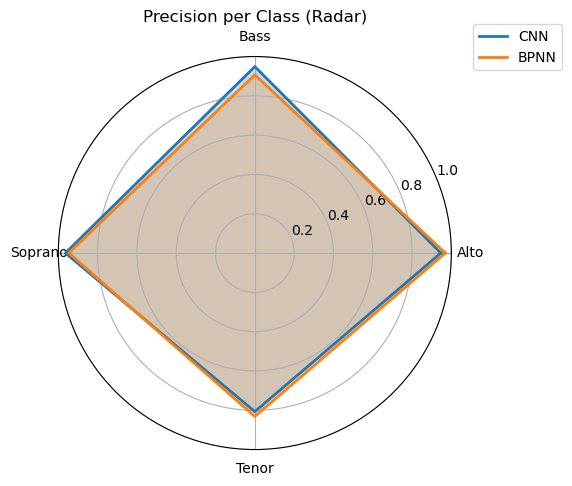

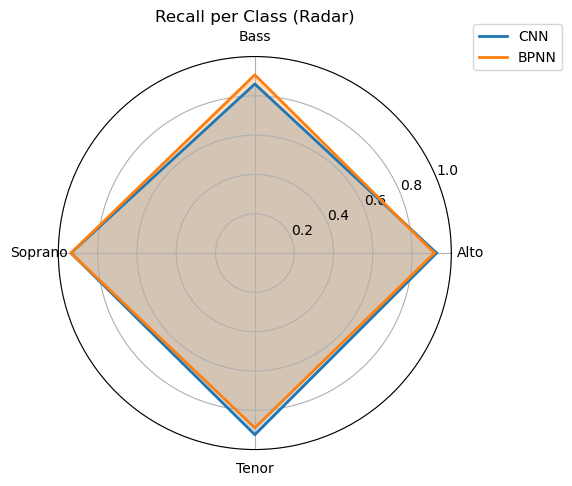

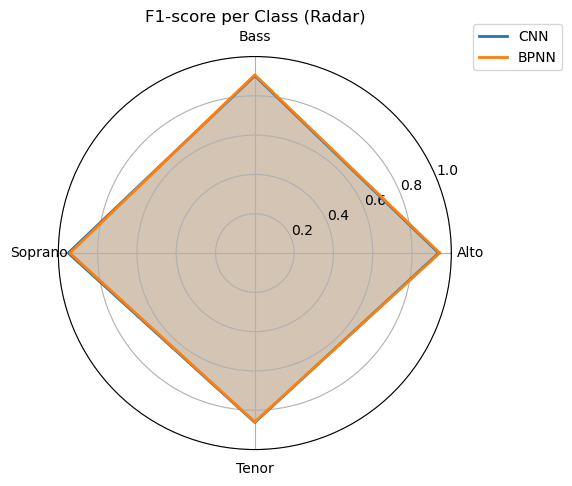

In [17]:
from sklearn.metrics import classification_report

report_cnn = classification_report(y_test, cnn_pred, output_dict=True, target_names=labels)
report_bpnn = classification_report(y_test, bpnn_pred, output_dict=True, target_names=labels)

plot_radar(report_dict_cnn=report_cnn, report_dict_bpnn=report_bpnn, labels=labels)


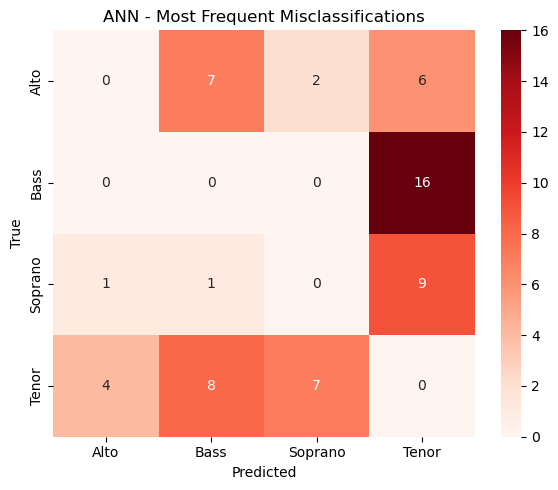

In [18]:
# Hitung jenis kesalahan
df_misclassified = pd.DataFrame({'True': y_test, 'Predicted': bpnn_pred})
conf_err = df_misclassified[df_misclassified['True'] != df_misclassified['Predicted']]
err_counts = conf_err.groupby(['True', 'Predicted']).size().unstack().fillna(0)

plt.figure(figsize=(6, 5))
sns.heatmap(err_counts, annot=True, cmap='Reds', fmt='.0f', xticklabels=labels, yticklabels=labels)
plt.title('ANN - Most Frequent Misclassifications')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

In [19]:
for layer in bpnn_model.layers:
    print(layer.name)


dense_3
dropout_4
dense_4
dropout_5
dense_5
dropout_6
dense_6


In [20]:
import tensorflow as tf
print(tf.__version__)


2.19.0


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


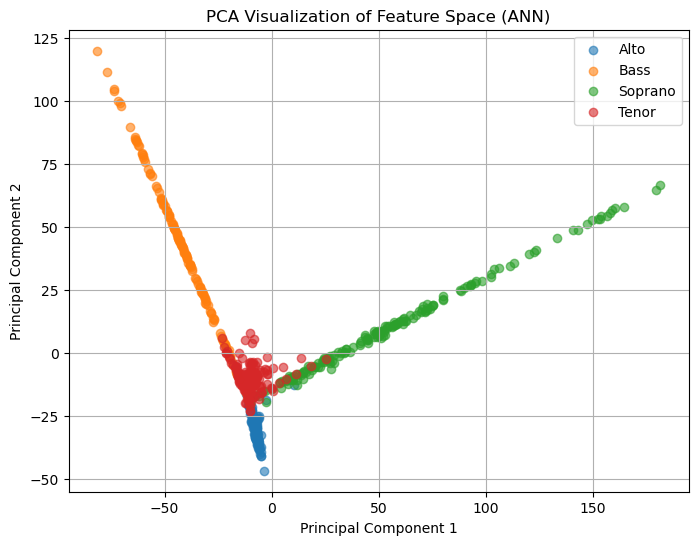

In [ ]:
from tensorflow.keras.models import Model
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# Buat model baru dari input ke layer 'dense_5' (hidden layer terakhir)
# Trik: Panggil model lewat X_test dan gunakan hasilnya sebagai input dummy

# Gunakan input shape dari data uji
input_dummy = X_test[:1]

# Jalankan satu prediksi agar model 'terpanggil'
bpnn_model.predict(input_dummy)

input_layer = tf.keras.Input(shape=X_test.shape[1:])
intermediate_output = bpnn_model.layers[0](input_layer)
for layer in bpnn_model.layers[1:bpnn_model.layers.index(bpnn_model.get_layer('dense_5')) + 1]:
    intermediate_output = layer(intermediate_output)

intermediate_model = Model(inputs=input_layer, outputs=intermediate_output)

hidden_features = intermediate_model.predict(X_test)

# PCA ke 2D
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(hidden_features)

# Plot PCA
plt.figure(figsize=(8, 6))
for label in np.unique(y_test):
    idx = y_test == label
    plt.scatter(reduced_features[idx, 0], reduced_features[idx, 1], label=le.classes_[label], alpha=0.6)

plt.title("PCA Visualization of Feature Space (ANN)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.grid(True)
plt.show()


Visualizing file: C:\Users\Asus\OneDrive\Documents\Kuliah\Sem 4\Research Methodology\RM MODEL\ChoralSingingDataset\CSD_ER_alto_1.wav


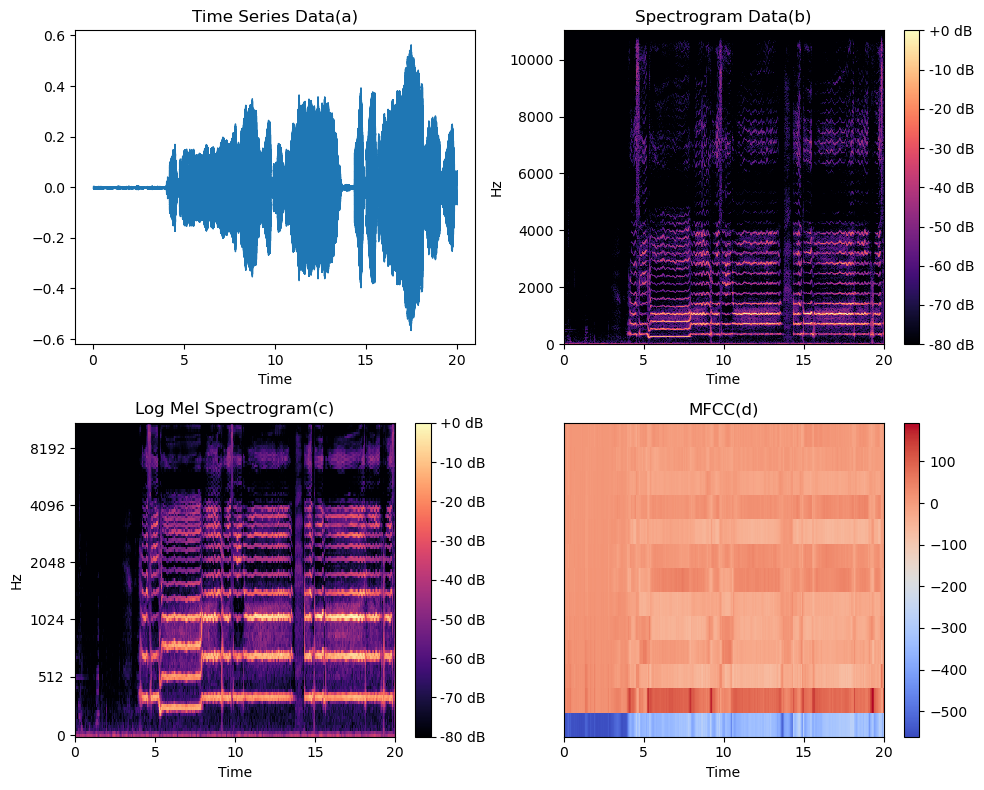

In [22]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Path ke folder yang berisi file WAV
# Ambil semua file .wav di folder
wav_files = [f for f in os.listdir(data_path) if f.endswith('.wav')]

# Pilih satu file (misalnya file pertama)
file_path = os.path.join(data_path, wav_files[0])
print(f"Visualizing file: {file_path}")

# Load audio
y, sr = librosa.load(file_path, duration=20)

# Compute features
D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

# Plotting
plt.figure(figsize=(10, 8))

# 1. Time series waveform
plt.subplot(2, 2, 1)
librosa.display.waveshow(y, sr=sr)
plt.title("Time Series Data(a)")

# 2. Linear Spectrogram
plt.subplot(2, 2, 2)
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear')
plt.colorbar(format='%+2.0f dB')
plt.title("Spectrogram Data(b)")

# 3. Log Mel Spectrogram
plt.subplot(2, 2, 3)
librosa.display.specshow(log_mel_spectrogram, sr=sr, x_axis='time', y_axis='mel')
plt.colorbar(format='%+2.0f dB')
plt.title("Log Mel Spectrogram(c)")

# 4. MFCCs
plt.subplot(2, 2, 4)
librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.colorbar()
plt.title("MFCC(d)")

plt.tight_layout()
plt.show()
